# 필요 라이브러리 설치 및 파일 셋업

In [ ]:
!pip install IPython 
# !pip install catboost
# !pip install optuna

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image 

import pandas as pd
import numpy as np
import matplotlib as plt
from matplotlib import pyplot as plt
from datetime import datetime
import time
from tqdm import tqdm
import time

In [4]:
# 50개까지 row 생략 없이 출력
pd.set_option('display.max_rows', 50)
# 50개까지 col 생략 없이 출력
pd.set_option('display.max_columns', 50)

In [5]:
user_spec = pd.read_csv("./../data/user_spec.csv") 
log_data = pd.read_csv("./../data/log_data.csv")
loan_result = pd.read_csv("./../data/loan_result.csv")

In [6]:
loan_result.columns=['신청서_번호', '한도조회_일시', '금융사_번호', '상품_번호', '승인한도', '승인금리', '신청_여부(y)']
log_data.columns=['유저_번호', '행동명', '행동일시', '운영체제', '앱_버전', '일_코드']
user_spec.columns=['신청서_번호', '유저_번호', '유저_생년월일', '유저_성별', '생성일시', '한도조회_당시_유저_신용점수', '연소득', '근로형태', '입사연월', '고용형태', '주거소유형태', '대출희망금액', '대출_목적', '개인회생자_여부', '개인회생자_납입_완료_여부', '기대출수', '기대출금액'] # 건강보험 타입이 정의서에는 있는데 데이터엔 없는듯

In [7]:
print('loan_result.shape:{}'.format(loan_result.shape))
print('log_data.shape:{}'.format(log_data.shape))
print('user_spec.shape:{}'.format(user_spec.shape))

loan_result.shape:(13527363, 7)
log_data.shape:(17843993, 6)
user_spec.shape:(1394216, 17)


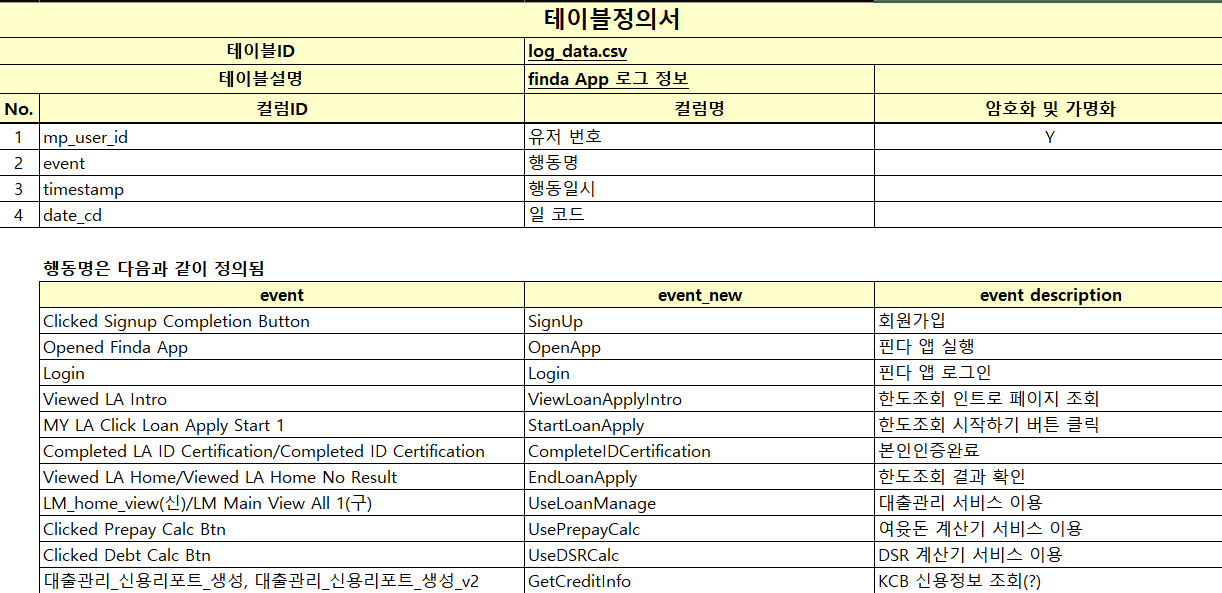

In [176]:
Image('./../data/log_data.png')

# 전처리

## 데이터 확인

In [72]:
log_data.head(10) # 상위 5개 확인

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초
0,576409,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,03,25,11,12,09
1,576409,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,03,25,11,12,09
2,72878,EndLoanApply,한도조회_결과_확인,2022-03-25 11:14:44,Android,3.8.4,2022-03-25,2022,03,25,11,14,44
3,645317,OpenApp,앱_실행,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25,2022,03,25,11,15,09
4,645317,UseLoanManage,대출관리_서비스_이용,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25,2022,03,25,11,15,11
5,640185,UseLoanManage,대출관리_서비스_이용,2022-03-25 11:41:53,iOS,3.6.1,2022-03-25,2022,03,25,11,41,53
6,640185,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-25 11:42:38,iOS,3.6.1,2022-03-25,2022,03,25,11,42,38
7,640185,UsePrepayCalc,여윳돈_계산기_서비스_이용,2022-03-25 11:43:07,iOS,3.6.1,2022-03-25,2022,03,25,11,43,07
8,640185,UseLoanManage,대출관리_서비스_이용,2022-03-25 11:43:57,iOS,3.6.1,2022-03-25,2022,03,25,11,43,57
9,640185,UseLoanManage,대출관리_서비스_이용,2022-03-25 11:44:04,iOS,3.6.1,2022-03-25,2022,03,25,11,44,04


In [73]:
log_data.info() # 컬럼 타입 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17843993 entries, 0 to 17843992
Data columns (total 13 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   유저_번호    int64 
 1   행동명      object
 2   행동명_kor  object
 3   행동일시     object
 4   운영체제     object
 5   앱_버전     object
 6   일_코드     object
 7   년        object
 8   월        object
 9   일        object
 10  시        object
 11  분        object
 12  초        object
dtypes: int64(1), object(12)
memory usage: 1.7+ GB


In [74]:
log_data.isnull().sum() # 결측치 확인 

유저_번호           0
행동명             0
행동명_kor         0
행동일시            0
운영체제            0
앱_버전       660597
일_코드            0
년               0
월               0
일               0
시               0
분               0
초               0
dtype: int64

## 결측치 처리
- 운영체제 결측 처리

In [75]:
log_data['운영체제'].unique()

array(['Android', 'iOS', 'iPadOS'], dtype=object)

android로 되어 있는 데이터들의 mp_os는 전부 GetCreditInfo에 해당된다 -> Android로 변환

In [76]:
log_data[log_data['운영체제']=='android']['행동명'].unique()

array([], dtype=object)

In [77]:
log_data.loc[list(log_data[log_data['운영체제']=='android'].index),'운영체제'] = 'Android'

In [78]:
log_data[log_data['운영체제'].isnull()].isnull().sum()

유저_번호      0
행동명        0
행동명_kor    0
행동일시       0
운영체제       0
앱_버전       0
일_코드       0
년          0
월          0
일          0
시          0
분          0
초          0
dtype: int64

- 유저 ID에 해당하는 mp_os가 nan만 있을경우: 처리 못함
- 유저 ID에 해당하는 mp_os가 1개 있을경우: 1개로 nan값 처리
    - ipados에 해당하는 경우 없어서 그냥 나머지 1개로 처리 가능할듯
- 유저 ID에 해당하는 mp_os가 2개 있을경우: 처리 못함

GetCreditInfo 과정에서 map_os에 대한 결측이 이뤄짐

In [79]:
log_data[log_data['운영체제'].isnull()]['행동명'].value_counts()

Series([], Name: 행동명, dtype: int64)

In [80]:
only_user_id = [] 
ios_user = []
android_user = []

count1 = 0
count2 = 0

null_mp_os = list(log_data[log_data['운영체제'].isnull()]['유저_번호'].unique()) # mp_os가 null값인 user_id 목록

for i in null_mp_os:
    if len(log_data[log_data['유저_번호']==i]['운영체제'].unique())==1:
        only_user_id.append(i)
        count1+=1
    if len(log_data[log_data['유저_번호']==i]['운영체제'].unique())==2:
        count2+=1
        if 'Android' in list(log_data[log_data['유저_번호']==i]['운영체제'].unique()):
            android_user.append(i)
        else: ios_user.append(i)    
print('mp_os의 정보가 나오지 않는 유저의 수: {}'.format(count1))
print('mp_os의 정보가 한개 나오는 유저의수: {}'.format(count2))

mp_os의 정보가 나오지 않는 유저의 수: 0
mp_os의 정보가 한개 나오는 유저의수: 0


In [81]:
# ios 유저일 경우 ios로 null값 처리
log_data.loc[log_data['유저_번호'].isin(ios_user),'운영체제'] = 'iOS'
# android 유저일 경우 android로 null값 처리
log_data.loc[log_data['유저_번호'].isin(android_user),'운영체제'] = 'Android'

In [82]:
log_data.isnull().sum()

유저_번호           0
행동명             0
행동명_kor         0
행동일시            0
운영체제            0
앱_버전       660597
일_코드            0
년               0
월               0
일               0
시               0
분               0
초               0
dtype: int64

In [83]:
log_data[log_data['운영체제'].isnull()]

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초


운영체제 중 andorid의 비중이 가장 크다

In [84]:
log_data['운영체제'].value_counts()

Android    14528099
iOS         3312865
iPadOS         3029
Name: 운영체제, dtype: int64

운영체제가 null값을 가지는 유저는 20명이라 android로 채워도 무방할듯

In [85]:
log_data[log_data['운영체제'].isnull()]['유저_번호'].unique()

array([], dtype=int64)

In [86]:
log_data.loc[log_data['운영체제'].isnull(),'운영체제'] ='Android'

mp_app_version이 null값인 경우 ios의 분포가 가장 높다.

In [87]:
log_data[log_data['앱_버전'].isnull()]['운영체제'].value_counts()

iOS        658681
Android       980
iPadOS        936
Name: 운영체제, dtype: int64

- android는 3.8.2, 435, 3.8.0.6.mydata 등 버전 형태가 다양하다
- ios는 3.6.1 형식의 버전만 존재

In [88]:
log_data[log_data['운영체제'] == 'Android']['앱_버전'].unique()

array(['3.8.2', '3.8.4', '3.8.1', '3.8.0', '3.5.0', '3.5.3', '3.7.0',
       '3.2.2', '3.13.0', '3.12.1', '3.11.1', '3.10.0', '3.2.0', '3.3.2',
       '3.5.2', '3.11.0', '3.10.1', '3.9.1', '3.12.0', '3.0.2', '3.3.1',
       '3.9.0', '3.15.0', '3.15.1', '3.14.0', '3.6.0', '3.4.0', '3.5.1',
       '2.31.2', '3.1.1', '2.28.1', '3.2.1', '3.1.0', '3.0.1', '3.10.0.7',
       '3.10.1.0-dsr', '3.0.0', '3.10.1.2', '3.12.0.0', '453', '417',
       '413', '435', '461', '422', '409', '356', '359', '462', '370',
       '459', '451', '421', '383', '401', '464', '448', '466', '447', nan,
       '407', '416', '396', '440', '460', '380', '465', '404', '426',
       '408', '360', '376', '354', '363', '449', '368', '433', '387',
       '399', '361', '405', '452', '373', '385', '390', '424', '397',
       '382', '389', '2.24.2', '2.28.3', '3.10.1.0', '2.28.4', '3.10.2.2',
       '2.28.6', '3.8.0.6.mydata', '381', '406', '400', '2.27.4', '365',
       '366', '374', '432', '403', '384', '353', '379', '463',

In [89]:
log_data[log_data['운영체제'] == 'iOS']['앱_버전'].unique()

array(['3.6.1', '3.6.0', '3.10.2', '3.10.1', '3.10.0', '3.7.0', '3.8.0',
       '3.13.0', nan, '3.8.1', '3.6.2', '3.12.0', '3.12.1', '3.13.2',
       '3.13.1', '2.2.8', '3.3.2', '3.3.1', '1.2.4', '3.1.1', '3.3.0',
       '3.2.4', '3.4.0', '3.5.0', '3.1.0', '3.2.2', '2.24.5', '1.6.5',
       '2.28.2', '3.0.1', '2.28.4', '2.31.1', '3.4.1', '2.27.0', '1.9.1',
       '2.0.7', '3.2.1', '2.25.3', '2.0.3', '1.9.8', '3.2.3', '2.23.3',
       '2.2.3', '2.22.4', '3.5.1', '3.11.0', '2.1.5', '2.30.4', '3.2.0',
       '2.2.9', '2.1.7', '1.2.1', '2.30.6', '2.24.3', '2.1.8', '2.28.3',
       '2.23.0', '2.22.6', '1.7.6', '2.28.5', '1.9.9', '2.24.4', '2.25.0',
       '1.1.7', '1.5.2', '2.25.1', '2.28.1', '1.8.4', '2.22.2', '1.0.1',
       '2.23.4', '2.2.7', '2.30.2', '1.6.4', '2.22.7', '2.30.0', '2.23.2',
       '1.5.5', '1.0.3', '3.13.3', '3.0.0', '1.6.1', '1.1.6', '2.24.2',
       '2.30.3', '1.4.1', '2.1.4', '1.3.6', '1.0.0', '2.23.1', '1.1.5',
       '1.0.5', '1.1.9', '2.30.1'], dtype=object)

## 이상치 확인

In [90]:
# 혹시 행동일시랑 일_코드랑 일자 일치 하지 않는 컬럼 있는지 확인

log_data["일_코드_확인"] = log_data["행동일시"].str[0:10]

for i in tqdm(range(17843993)) :
    if log_data.일_코드.loc[i] != log_data.일_코드_확인.loc[i] :
        print(log_data.loc[i])
    else : continue

print("검사종료")

100%|██████████| 17843993/17843993 [10:56<00:00, 27200.15it/s]

검사종료


## 행동명 한글 맵핑

In [91]:

# 범주형 변수의 항목 매핑/변환에 사용할 기준 정보를 dict 자료형으로 만들기
name_mapping = {
                    "SignUp"                  : "회원가입",
                    "OpenApp"                 : "앱_실행" ,
                    "Login"                   : "로그인" ,
                    "ViewLoanApplyIntro"      : "한도조회_인트로_페이지_조회",
                    "StartLoanApply"          : "한도조회_시작하기_버튼_클릭" ,
                    "CompleteIDCertification" : "본인인증완료", 
                    "EndLoanApply"            : "한도조회_결과_확인" ,
                    "UseLoanManage"           : "대출관리_서비스_이용" ,
                    "UsePrepayCalc"           : "여윳돈_계산기_서비스_이용" ,
                    "UseDSRCalc"              : "DSR_계산기_서비스_이용" ,
                    "GetCreditInfo"           : "KCB_신용정보_조회" ,
                } 

# dict.get() 함수를 이용하여 매핑/변환에 사용할 사용자 정의 함수 만들기
func = lambda x: name_mapping.get(x, x)

In [92]:
# map() 함수로 매핑용 사용자 정의 함수를 DataFrame의 범주형 변수에 적용하여 매핑/변환하기
log_data["행동명_kor"] =  log_data.행동명.map(func)

 # 컬럼 순서 변경
log_data = log_data[["유저_번호", "행동명", "행동명_kor", "행동일시", "운영체제", "앱_버전", "일_코드"]]

In [93]:
# 행동명 잘 매핑됐는지 확인
print("행동명_eng :", "\n" ,log_data.행동명.unique())

print("\n")

print("행동명_kor :", "\n" ,log_data.행동명_kor.unique())

행동명_eng : 
 ['StartLoanApply' 'ViewLoanApplyIntro' 'EndLoanApply' 'OpenApp'
 'UseLoanManage' 'UsePrepayCalc' 'Login' 'CompleteIDCertification'
 'UseDSRCalc' 'SignUp' 'GetCreditInfo']


행동명_kor : 
 ['한도조회_시작하기_버튼_클릭' '한도조회_인트로_페이지_조회' '한도조회_결과_확인' '앱_실행' '대출관리_서비스_이용'
 '여윳돈_계산기_서비스_이용' '로그인' '본인인증완료' 'DSR_계산기_서비스_이용' '회원가입' 'KCB_신용정보_조회']


In [94]:
# 행동일시 년월일시분초 로 slicing

log_data["년"] = log_data["행동일시"].str[0:4]
log_data["월"] = log_data["행동일시"].str[5:7]
log_data["일"] = log_data["행동일시"].str[8:10]
log_data["시"] = log_data["행동일시"].str[11:13]
log_data["분"] = log_data["행동일시"].str[14:16]
log_data["초"] = log_data["행동일시"].str[17:19]

In [95]:
# 행동일시 slicing 확인

log_data.head()

,유저_번호,행동명,행동명_kor,행동일시,운영체제,앱_버전,일_코드,년,월,일,시,분,초
0,576409,StartLoanApply,한도조회_시작하기_버튼_클릭,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,03,25,11,12,09
1,576409,ViewLoanApplyIntro,한도조회_인트로_페이지_조회,2022-03-25 11:12:09,Android,3.8.2,2022-03-25,2022,03,25,11,12,09
2,72878,EndLoanApply,한도조회_결과_확인,2022-03-25 11:14:44,Android,3.8.4,2022-03-25,2022,03,25,11,14,44
3,645317,OpenApp,앱_실행,2022-03-25 11:15:09,iOS,3.6.1,2022-03-25,2022,03,25,11,15,09
4,645317,UseLoanManage,대출관리_서비스_이용,2022-03-25 11:15:11,iOS,3.6.1,2022-03-25,2022,03,25,11,15,11


In [96]:
log_data.to_csv("log_data_pre") # 해당 전처리 내용을 담은 데이터 export _ log_data_pre.csv